In [ ]:
from matplotlib import pyplot as plt

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from dateutil.parser import parse

# Creating global to store various link and its modified time 
modified_time =[]
internal_link_count=[]
url_fragment_count=[]
external_link_count=[]

# Function to parse the html file using beautifulsoup
def beautiful_soup(url):
   page_response = requests.get(url)  #Getting raw data from URL
   raw_data = BeautifulSoup(page_response.content, 'html.parser')
   extract_timestamp(raw_data)
   return raw_data

# Function to extract links
def extract_links(raw_data):
  links=[]
  anchor_data = raw_data.find_all('a')   # Extracting out the 'a' tagged elements
  for link in anchor_data:
    if 'href' in link.attrs:
      links.append(str(link.attrs['href']))
  return links

# Function to extract the last time the page was modified 
def extract_timestamp(raw_data):
  #Extracting out the 'li' tagged element w.r.t the id(i.e the timestamp regarding when the article was last modified)
  time_stamp =  raw_data.find('li', id = "footer-info-lastmod")
  if time_stamp == None:
    modified_time.append('None')
  else:
    time_stamp= ''.join(map(str,(time_stamp.string).split()[6:]))
    modified_time.append(parse(time_stamp).strftime('%Y-%m-%d::%H-%M'))

# Fuction for grouping the links into internal, external and the links that reference contents within the same page (url fragments)
def categorize_links(link_bucket):
  internal_links=[]
  url_fragments= []
  external_links= []
  for i in link_bucket:
    if i.startswith('/wiki/'):
      internal_links.append(i)
    elif i.startswith('#'):
      url_fragments.append(i)
    elif i.startswith('https:'):
      external_links.append(i)
  # Keeping a track of count of each link type
  internal_link_count.append(len(internal_links))
  url_fragment_count.append(len(url_fragments))
  external_link_count.append(len(external_links))
  return internal_links

more_internal_links_list=[]
def internal_link(inner_links):
  #print(internal_link_count)
  for i in inner_links:
    if len(internal_link_count)< 200:
      new_link = "https://simple.wikipedia.org" + i
      fetched_links = extract_links(beautiful_soup(new_link))
      more_internal_links = categorize_links(fetched_links)
    more_internal_links_list.append(more_internal_links)  

def extract_more_internal_link(more_internal_links):
  more_links = more_internal_links_list[0]
  crawl = internal_link(more_links)
  return crawl 

# Scraping the initial link
initial_url = 'https://simple.wikipedia.org/wiki/Climate_change'
link_bucket= extract_links(beautiful_soup(initial_url))
initial_internal_links= categorize_links(link_bucket)
int_links= internal_link(initial_internal_links)
int_links1= extract_more_internal_link(int_links)


num=[]
for x in range(1,201):
  num.append(x)

#Organizing the collected data into a dataframe
df= {'Pagecount' : num,
                  'INTcount' : internal_link_count,
                  'EXTcount' : external_link_count,
                  'URLfragments' : url_fragment_count,
     'timestamp' : modified_time}
data= pd.DataFrame(df)
print(data)


     Pagecount  INTcount  EXTcount  URLfragments          timestamp
0            1        41        99            18  2021-11-13::15-04
1            2       190       189            93  2021-12-04::04-18
2            3        51       153             4  2021-10-05::18-32
3            4       663       329           173  2021-11-28::04-18
4            5       190       189            93  2021-12-04::04-18
..         ...       ...       ...           ...                ...
195        196        43        28             2  2019-05-21::11-07
196        197        32        69             8  2020-12-30::22-56
197        198        51       116            18  2021-05-25::04-13
198        199       231        37             2  2021-08-09::09-44
199        200       506       265           275  2021-11-22::19-03

[200 rows x 5 columns]


Internal Links -> Mean: 138.635, Median: 67.0


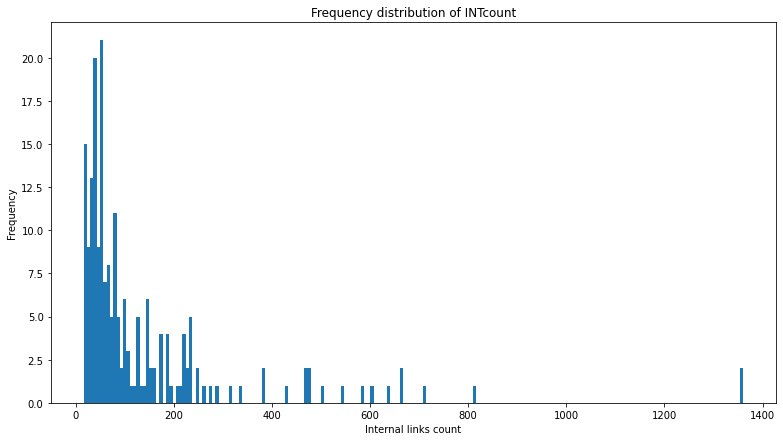

External Links-> Mean: 130.515, Median: 109.0


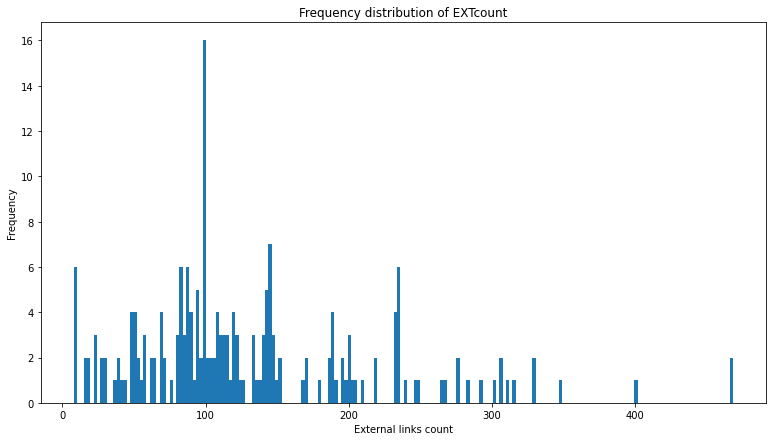

URLfragments-> Mean: 28.535, Median: 12.0


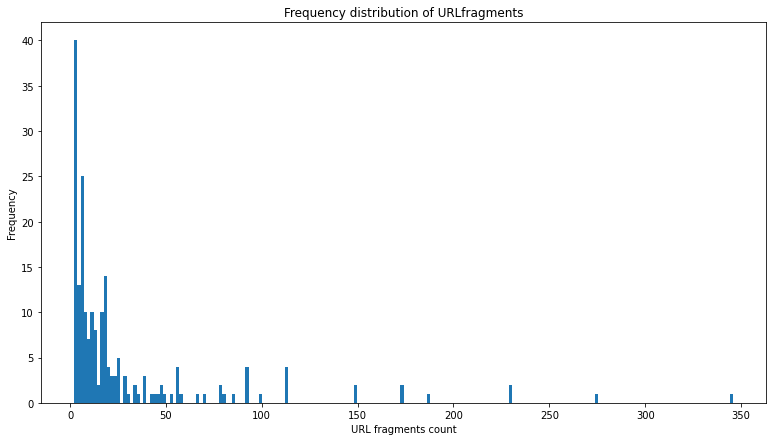

AttributeError: ignored

In [ ]:
# Using pandas mean and median function to find the respective values of Internal links count
mean_int = data['INTcount'].mean()
median_int = data['INTcount'].median()
print ("Internal Links -> Mean: {}, Median: {}".format(mean_int, median_int))

# Histogram visualization of internal links using 200 bins
fig_int= plt.figure(figsize=(13, 7))
plt.hist(df['INTcount'], bins=200)
plt.xlabel("Internal links count")
plt.ylabel("Frequency")
plt.title("Frequency distribution of INTcount")
fig_int.savefig('internal_links_count.jpg')
plt.show()

# Using pandas mean and median function to find the respective values of External links count
mean_int = data['EXTcount'].mean()
median_int = data['EXTcount'].median()
print ("External Links-> Mean: {}, Median: {}".format(mean_int, median_int))

# Histogram visualization of external links using 200 bins
fig_ext= plt.figure(figsize=(13, 7))
plt.hist(df['EXTcount'], bins=200)
plt.xlabel("External links count")
plt.ylabel("Frequency")
plt.title("Frequency distribution of EXTcount")
fig_ext.savefig('external_links_count.jpg')
plt.show()

# Using pandas mean and median function to find the respective values of URL Fragments links count
mean_int = data['URLfragments'].mean()
median_int = data['URLfragments'].median()
print ("URLfragments-> Mean: {}, Median: {}".format(mean_int, median_int))

# Histogram visualization of URL fragment links using 200 bins
fig_urlfragment= plt.figure(figsize=(13, 7))
plt.hist(df['URLfragments'], bins=200)
plt.xlabel("URL fragments count")
plt.ylabel("Frequency")
plt.title("Frequency distribution of URLfragments")
fig_urlfragment.savefig('url_fragment_count.jpg')
plt.show()

# While looking at the data (as well as histograms )we can see that column EXTcount is evenly distributed
# and hence mean is more relevant here but in INTcount and URLfragments median looks more accurate 
# because these have outliers which has altered the mean.

new_df = data.copy()
new_df.dropna(inplace = True) # Dropping None or Na values

# Created a new column for calculating hour of the modified time
new_df['hours'] = new_df['timestamp'].dt.strftime('%H')
new_df.head()

# To find the distribution we have found the frequency of modification at particular hour
new_df['freq'] = new_df.groupby('hours')['hours'].transform('count')
new_df.sort_values(['hours'], ascending=[True], inplace = True)

# We have ploted a Line chart for frequency distribution, It can also be visualized using other charts using same values
plt.figure(figsize=(16, 8))
plt.plot(new_df['hours'], new_df['freq'], marker='o')
plt.xlabel("Hour of day")
plt.ylabel("Number of pages modified")
plt.title("Frequency distribution for pages modified at what time")
plt.show()